<a href="https://colab.research.google.com/github/pdrobny/MonReader/blob/main/P4_PaulNet_WnB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns
import tensorflow as tf
import random
import wandb
from tensorflow.keras import layers, models
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, AvgPool2D, Conv2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# define a confusion matrix plotter for visualizing classification report results
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='d'); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['flip', 'not flip']); ax.yaxis.set_ticklabels(['flip', 'not flip'])
    plt.show()

In [3]:
# load files from google drive

from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
class PaulNet:
      def __init__(self, optimizer, num_epochs, batch, pooling_type):
        self.optimizer = optimizer # examples: 'adam', 'sgb', 'lion
        self.num_epochs = num_epochs
        self.batch = batch # examples:  32, 64, 128
        self.pooling_type = pooling_type # 'max' for MaxPooling2D, 'avg' for AvgPool2D

      def pageflip(self):
        #define configuration options
        img_rows, img_cols = 150, 150
        batch_size = self.batch
        n_epochs = 5
        n_classes = 2
        val_split = 0.2
        verbosity = 1
        path = '/content/drive/MyDrive/Colab Notebooks/Apziva/MonReader/images/training'
        path_test = '/content/drive/MyDrive/Colab Notebooks/Apziva/MonReader/images/testing'
        input_shape = (img_rows, img_cols, 3)
        labels = ['flip', 'notflip']
        seed = 42

        # Data generators
        train_datagen = ImageDataGenerator(rescale=1./255, validation_split=val_split)

        val_datagen = ImageDataGenerator(rescale=1./255, validation_split=val_split)

        test_datagen = ImageDataGenerator(rescale=1./255)

        train_generator = train_datagen.flow_from_directory(
            directory = path,
            seed = seed,
            batch_size = batch_size,
            class_mode='binary',
            shuffle = True,
            target_size=(img_rows, img_cols),
            subset = 'training'
        )

        val_generator = val_datagen.flow_from_directory(
            directory = path,
            seed = seed,
            batch_size = batch_size,
            class_mode='binary',
            shuffle = True,
            target_size=(img_rows, img_cols),
            subset = 'validation'
        )

        test_generator = test_datagen.flow_from_directory(
            directory = path_test,
            seed = seed,
            batch_size = batch_size,
            class_mode='binary',
            shuffle = True,
            target_size=(img_rows, img_cols)
        )
        print(train_generator.class_indices)
        print(val_generator.class_indices)
        print(test_generator.class_indices)

        # Choose pooling layer based on self.pooling_type
        if self.pooling_type == 'max':
          pooling_layer = MaxPooling2D(pool_size=(2, 2))
        elif self.pooling_type == 'avg':
          pooling_layer = AvgPool2D(pool_size=(2, 2))
        else:
          raise ValueError("pooling_type must be 'max' or 'avg'")

        # Model architecture
        model = models.Sequential([
            layers.Input(shape=(img_rows, img_cols, 3)),

            layers.Conv2D(32, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            pooling_layer,
            layers.Dropout(0.25),

            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            pooling_layer,
            layers.Dropout(0.25),

            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(.5),
            layers.Dense(1, activation='sigmoid')  # Binary classification: flipped or not flipped
        ])

        # print the summary of the model
        print(model.summary())

        # compile model
        model.compile(optimizer=self.optimizer, loss='binary_crossentropy', metrics=['accuracy'])  #choose optimizer 'adam', 'sgd', or 'lion'
        # Train the model
        flip_model = model.fit(train_generator,
                                      steps_per_epoch=5,
                                      epochs=self.num_epochs,
                                      validation_data=val_generator,
                                      validation_steps=val_generator.samples // batch_size,
                                      verbose=1)
        return model, flip_model, test_generator

      def flip_test(self):
        # plot loss curves
          history = flip_model
          plt.figure(figsize=(5, 5))
          plt.plot(history.history['loss'], label='Training Loss')
          plt.plot(history.history['val_loss'], label='Validation Loss')
          plt.title('Loss Curve')
          plt.xlabel('Epochs')
          plt.ylabel('Loss')
          plt.legend()
          plt.show()

          #plot accuracy curves
          plt.figure(figsize=(5, 5))
          plt.plot(history.history['accuracy'], label='Training Accuracy')
          plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
          plt.title('Accuracy Curve')
          plt.xlabel('Epochs')
          plt.ylabel('Accuracy')
          plt.legend()
          plt.show()

          # Predict on new data (example)
          sample_images, sample_labels = next(test_generator)
          predictions = model.predict(sample_images)
          predicted_classes = (predictions > 0.5).astype(int)
          y_true = sample_labels
          class_names = list(test_generator.class_indices.keys())
          # Show some predicted images
          for i in range(5):
              plt.imshow(sample_images[i])
              true_label = class_names[int(sample_labels[i])]
              predicted_label = 'flip' if predicted_classes[i][0] == 0 else 'notflip'
              plt.title(f"Actual: {true_label}, Predicted: {predicted_label}")
              plt.axis('off')
              plt.show()

          # Generate the classification report
          print(classification_report(y_true, predicted_classes, target_names=class_names))
          # plot confusion matrix
          plot_confusion_matrix(y_true, predicted_classes)


In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pdrobny (pdrobny-dominicap-trading) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
#select attribute values
optimizer = 'lion' # examples: 'adam', 'sgd', 'lion
num_epochs = 3 # examples:5, 10, 15
batch = 32 # examples:  32, 64, 128
pooling_type = 'max' # 'max' for MaxPooling2D, 'avg' for AvgPool2D

# Start a new wandb run to track this script.
run = wandb.init(
    project='test run',
    notes='set shuffle = true for all 3 data sets',
    config={
        'optimizer': optimizer,
        'num_epochs': num_epochs,
        'batch': batch,
        'pooling_type': pooling_type
    }
)


#pass selected attributes to new object
build = PaulNet(optimizer, num_epochs, batch, pooling_type)

# run the pageflip flip method on build object
model, flip_model, test_generator = build.pageflip()

# log metrics
wandb.log({'accuracy': flip_model.history['accuracy'][-1]})
wandb.log({'loss': flip_model.history['loss'][-1]})
wandb.log({'val_accuracy': flip_model.history['val_accuracy'][-1]})
wandb.log({'val_loss': flip_model.history['val_loss'][-1]})

# Finish the run
wandb.finish()

Found 1238 images belonging to 2 classes.
Found 308 images belonging to 2 classes.
Found 597 images belonging to 2 classes.
{'flip': 0, 'notflip': 1}
{'flip': 0, 'notflip': 1}
{'flip': 0, 'notflip': 1}


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,636,865 (40.58 MB)

 Trainable params: 10,636,673 (40.58 MB)

 Non-trainable params: 192 (768.00 B)

None


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6644 - loss: 19.4946

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 6s/step - accuracy: 0.6828 - loss: 18.9297 - val_accuracy: 0.2431 - val_loss: 4.7170
Epoch 2/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - accuracy: 0.8334 - loss: 5.7760 - val_accuracy: 0.2500 - val_loss: 1.9968
Epoch 3/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 9s/step - accuracy: 0.8991 - loss: 1.3521 - val_accuracy: 0.2986 - val_loss: 2.0364


accuracy,▁
loss,▁
val_accuracy,▁
val_loss,▁
accuracy,0.8875
loss,1.53908
val_accuracy,0.29861
val_loss,2.03645


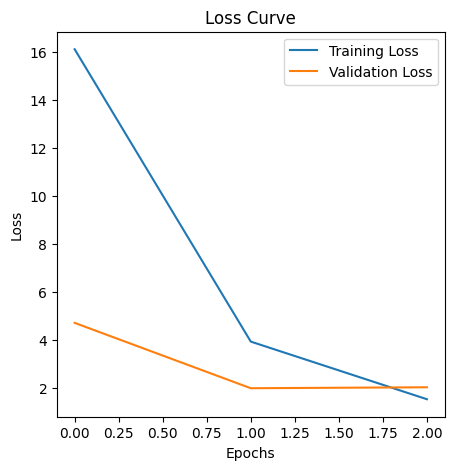

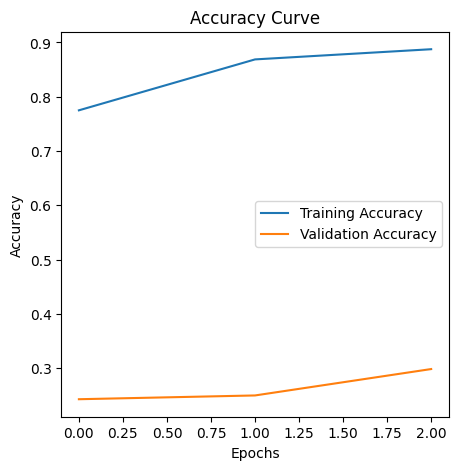

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


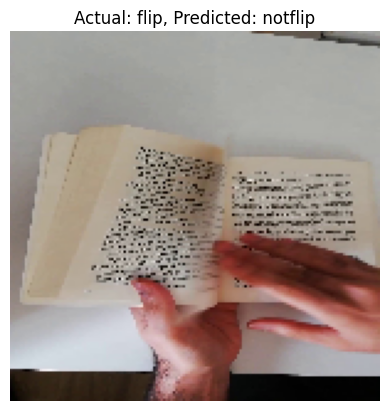

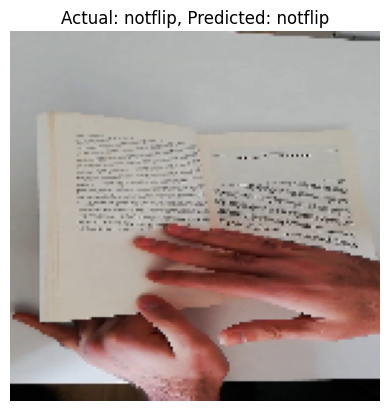

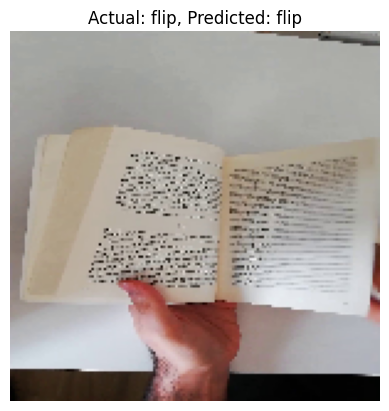

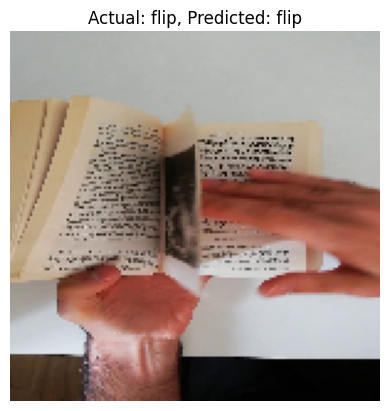

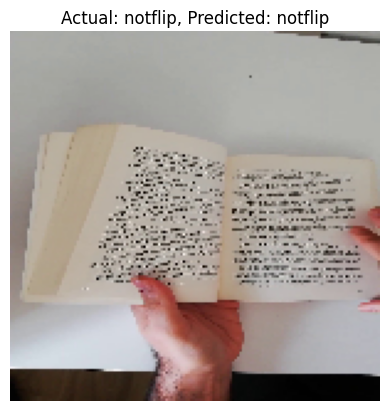

              precision    recall  f1-score   support

        flip       0.52      0.69      0.59        16
     notflip       0.55      0.38      0.44        16

    accuracy                           0.53        32
   macro avg       0.53      0.53      0.52        32
weighted avg       0.53      0.53      0.52        32



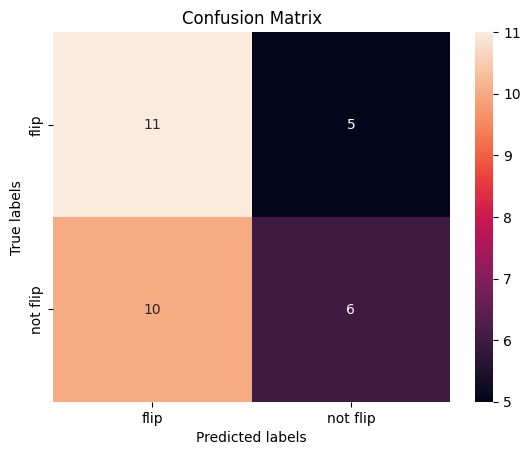

In [ ]:
build.flip_test()